Linhas: 3168 | Features: 20 | Classes: ['female', 'male']

Proporção das classes (contagem e %):
label
male      1584
female    1584
Name: count, dtype: int64
label
male      50.0 %
female    50.0 %
Name: proportion, dtype: object


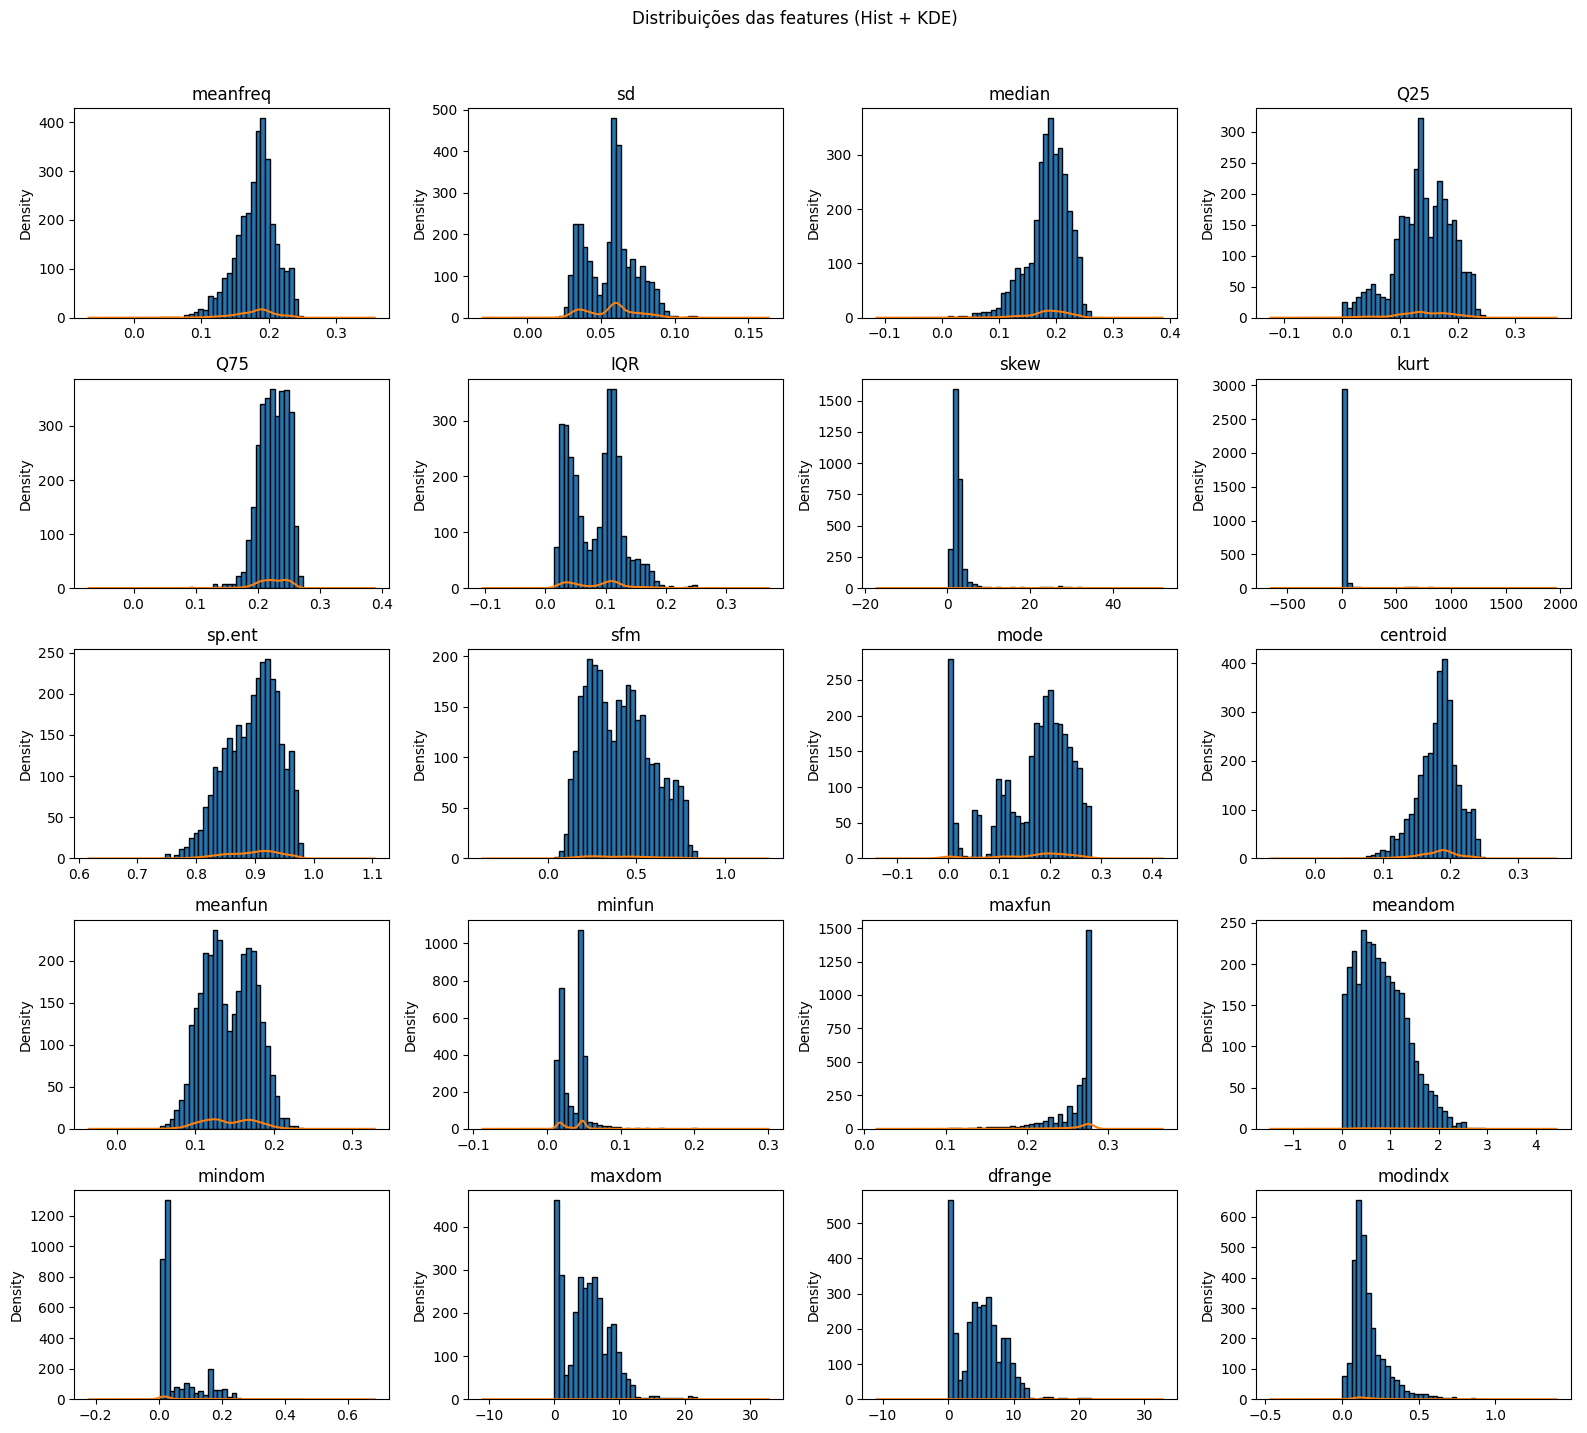

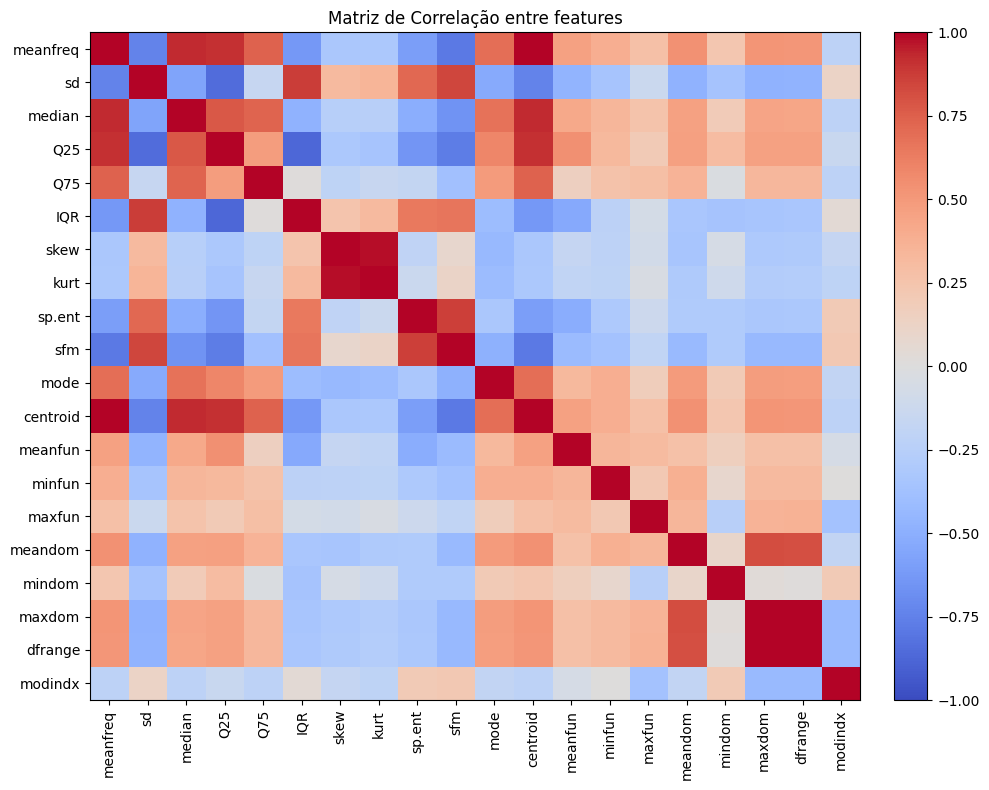


Top 10 pares com maior |correlação| (sugere multicolinearidade):
     feat_1    feat_2  abs_corr
0  meanfreq  centroid  1.000000
1    maxdom   dfrange  0.999838
2      skew      kurt  0.977020
3  meanfreq    median  0.925445
4    median  centroid  0.925445
5  meanfreq       Q25  0.911416
6       Q25  centroid  0.911416
7        sd       IQR  0.874660
8       Q25       IQR  0.874189
9    sp.ent       sfm  0.866411

Resumo de escala (top 8 maiores ranges):
              mean         std       min          max        range
kurt     36.568461  134.928661  2.068455  1309.612887  1307.544432
skew      3.140168    4.240529  0.141735    34.725453    34.583718
maxdom    5.047277    3.521157  0.007812    21.867188    21.859375
dfrange   4.994630    3.520039  0.000000    21.843750    21.843750
meandom   0.829211    0.525205  0.007812     2.957682     2.949870
modindx   0.173752    0.119454  0.000000     0.932374     0.932374
sfm       0.408216    0.177521  0.036876     0.842936     0.806059
mind

In [8]:
# Bloco 1 — Preparação + EDA (simples, LOCAL) — Regressão Logística (Voice Gender)
# O que este bloco faz (objetivo do enunciado):
# 1) Carrega o CSV local e cria X (features) e y (alvo).
# 2) Verifica balanceamento do alvo.
# 3) Plota distribuições das features (hist + curva de densidade).
# 4) Calcula matriz de correlação e lista pares com |cor| alto (multicolinearidade).
# 5) Mostra diferenças de escala e responde, em comentários curtos, sobre padronização.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Carregamento do CSV
# -------------------------
PATH = r"C:\Users\pedro\Downloads\IA-CP2\voice.csv"
if not os.path.exists(PATH):
    # fallback: caso você copie o arquivo para a mesma pasta do notebook
    PATH = "voice.csv"

df = pd.read_csv(PATH)
y = df["label"]                 # 'male' / 'female'
X = df.drop(columns=["label"])  # features numéricas

print(f"Linhas: {df.shape[0]} | Features: {X.shape[1]} | Classes: {sorted(y.unique().tolist())}")

# -------------------------------
# 2) Balanceamento do alvo (y)
# -------------------------------
print("\nProporção das classes (contagem e %):")
print(y.value_counts())
print((y.value_counts(normalize=True)*100).round(2).astype(str) + " %")
# Resposta: normalmente o dataset é ~balanceado (~50/50), o que é favorável para validação dos modelos.

# -------------------------------------------------------
# 3) Distribuição das features (histogramas + densidade)
# -------------------------------------------------------
axes = X.hist(bins=30, figsize=(16, 14), edgecolor="black", grid=False)
# sobrepor densidade (KDE) em cada histograma
for col, ax in zip(X.columns, axes.ravel()):
    if ax is None:
        continue
    try:
        X[col].plot(kind="kde", ax=ax)
    except Exception:
        pass
plt.suptitle("Distribuições das features (Hist + KDE)", y=1.02)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 4) Correlação e multicolinearidade (simples)
# -----------------------------------------------
corr = X.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de Correlação entre features")
plt.tight_layout()
plt.show()

# Top pares com maior |cor| (sinal de multicolinearidade)
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .rename("abs_corr")
    .reset_index()
    .rename(columns={"level_0": "feat_1", "level_1": "feat_2"})
)
print("\nTop 10 pares com maior |correlação| (sugere multicolinearidade):")
print(pairs.head(10))
# Resposta: há pares altamente correlacionados (medidas acústicas relacionadas), o que indica multicolinearidade.
# Em regressão logística, isso pode instabilizar coeficientes; regularização (L1/L2) ajuda.

# -------------------------------------------------
# 5) Escalas diferentes → justificar padronização
# -------------------------------------------------
stats = X.describe().T[["mean", "std", "min", "max"]]
stats["range"] = stats["max"] - stats["min"]
print("\nResumo de escala (top 8 maiores ranges):")
print(stats.sort_values("range", ascending=False).head(8).round(6))

# Resposta (padronização):
# • As features têm escalas/unidades distintas → é NECESSÁRIO padronizar (StandardScaler)
#   antes da regressão logística com regularização (Lasso/Ridge) e validação.
# • Padronização estabiliza a otimização, torna as penalizações comparáveis e melhora a interpretação.


In [9]:
# Bloco 2 — GridSearchCV (StandardScaler + LogisticRegression)
# O que faz:
# • Padroniza as features (StandardScaler).
# • Busca em grade (k-fold=5) por penalidade (L1/L2) e C ∈ [0.01, 0.1, 1, 10, 100].
# • Reporta a melhor combinação (média de validação).

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# --- Garante X e y_bin (0=female, 1=male) mesmo se este bloco rodar isolado ---
try:
    X, y_bin
except NameError:
    PATH = r"C:\Users\pedro\Downloads\IA-CP2\voice.csv"
    if not os.path.exists(PATH):
        PATH = "voice.csv"
    df = pd.read_csv(PATH)
    y_bin = df["label"].map({"female": 0, "male": 1})
    X = df.drop(columns=["label"])

# Pipeline: padronização + regressão logística
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="liblinear", max_iter=2000))
])

# Grade de hiperparâmetros: penalidade e C
param_grid = {
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [0.01, 0.1, 1, 10, 100],
    # solver "liblinear" aceita L1 e L2 para binário
}

# Validação cruzada estratificada (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search (métrica simples: acurácia)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

grid.fit(X, y_bin)

# Resultado pedido: melhor combinação e desempenho médio
print("Melhores parâmetros:", grid.best_params_)
print(f"Melhor acurácia média (validação 5-fold): {grid.best_score_:.4f}")

# (Opcional) tabela resumida de todos os testes
res = pd.DataFrame(grid.cv_results_)
cols = ["param_logreg__penalty", "param_logreg__C", "mean_test_score", "std_test_score", "rank_test_score"]
print("\nResumo da busca (ordenado por rank):")
print(res[cols].sort_values("rank_test_score").reset_index(drop=True).round(4))


Melhores parâmetros: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Melhor acurácia média (validação 5-fold): 0.9725

Resumo da busca (ordenado por rank):
  param_logreg__penalty  param_logreg__C  mean_test_score  std_test_score  \
0                    l1             0.10           0.9725          0.0083   
1                    l2             1.00           0.9713          0.0074   
2                    l1            10.00           0.9713          0.0069   
3                    l1             1.00           0.9710          0.0073   
4                    l2            10.00           0.9710          0.0070   
5                    l1           100.00           0.9710          0.0070   
6                    l2           100.00           0.9710          0.0070   
7                    l2             0.10           0.9706          0.0076   
8                    l1             0.01           0.9621          0.0066   
9                    l2             0.01           0.9615          0.0112   



In [10]:
# Bloco 3 — Modelo Final (treino/teste) + métricas no TESTE
# Reajusta com os melhores hiperparâmetros e reporta:
# acurácia, precisão, recall, F1 e matriz de confusão no conjunto de TESTE.

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# --- Garantir X e y_bin mesmo se este bloco rodar isolado ---
try:
    X, y_bin
except NameError:
    PATH = r"C:\Users\pedro\Downloads\IA-CP2\voice.csv"
    if not os.path.exists(PATH):
        PATH = "voice.csv"
    df = pd.read_csv(PATH)
    y_bin = df["label"].map({"female": 0, "male": 1})
    X = df.drop(columns=["label"])

# --- Split treino/teste (estratificado) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.20, stratify=y_bin, random_state=42
)

# --- Hiperparâmetros: usa os melhores do GridSearch anterior, se existirem; senão, roda Grid no TREINO ---
best_params = None
if "grid" in globals():
    try:
        best_params = grid.best_params_
    except Exception:
        best_params = None

if best_params is None:
    pipe_tmp = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(solver="liblinear", max_iter=2000))
    ])
    param_grid = {
        "logreg__penalty": ["l1", "l2"],
        "logreg__C": [0.01, 0.1, 1, 10, 100],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_train = GridSearchCV(
        estimator=pipe_tmp,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    grid_train.fit(X_train, y_train)
    best_params = grid_train.best_params_

print("Melhores hiperparâmetros usados:", best_params)

# --- Reajuste final no TREINO com os melhores hiperparâmetros ---
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        solver="liblinear",
        penalty=best_params["logreg__penalty"],
        C=best_params["logreg__C"],
        max_iter=2000
    ))
])
final_pipe.fit(X_train, y_train)

# --- Avaliação no TESTE ---
y_pred = final_pipe.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)  # pos_label=1 (male)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
cm   = confusion_matrix(y_test, y_pred)

print("\n=== Métricas no conjunto de TESTE ===")
print(f"Acurácia : {acc:.4f}")
print(f"Precisão : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nMatriz de confusão [ [TN FP] ; [FN TP] ]:")
print(cm)

# (Opcional) relatório detalhado por classe
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["female(0)", "male(1)"], zero_division=0))


Melhores hiperparâmetros usados: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}

=== Métricas no conjunto de TESTE ===
Acurácia : 0.9716
Precisão : 0.9600
Recall   : 0.9842
F1-score : 0.9720

Matriz de confusão [ [TN FP] ; [FN TP] ]:
[[304  13]
 [  5 312]]

Classification report:
              precision    recall  f1-score   support

   female(0)       0.98      0.96      0.97       317
     male(1)       0.96      0.98      0.97       317

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



=== Modelo RMSE (sigmoide + MSE) — TESTE ===
Acurácia: 0.9700
AUC-ROC : 0.9971


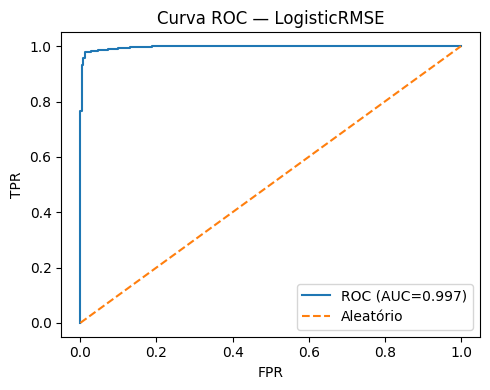

In [11]:
# Bloco 5 — Parte B: Regressão "Logística" treinada por RMSE (em vez de log-loss)
# Objetivo do enunciado:
# • Ajustar um modelo onde a predição é sigmoide(w^T x + b), mas a FUNÇÃO DE PERDA otimizada é RMSE
#   entre p (probabilidade prevista) e y (0/1), em vez da log-loss padrão.
# • Treinar e reportar ACURÁCIA e CURVA ROC no conjunto de TESTE.
#
# Observação: isto é apenas para fins didáticos. Em produção, use a regressão logística padrão
# (log-loss) do scikit-learn. Aqui implementamos gradiente descendente "na mão".

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

# -------------------------------------------------
# 1) Carregar dados (LOCAL) e preparar X, y (0/1)
# -------------------------------------------------
try:
    X, y_bin
except NameError:
    PATH = r"C:\Users\pedro\Downloads\IA-CP2\voice.csv"
    if not os.path.exists(PATH):
        PATH = "voice.csv"
    df = pd.read_csv(PATH)
    y_bin = df["label"].map({"female": 0, "male": 1}).astype(float).values
    X = df.drop(columns=["label"]).values
else:
    # Se já existirem (de blocos anteriores), garanta que são arrays NumPy
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y_bin, (pd.Series, pd.DataFrame)):
        y_bin = y_bin.values.astype(float)

# Split estratificado 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.20, stratify=y_bin, random_state=42
)

# Padronização (necessário para gradiente ficar estável e justa penalização)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# -------------------------------------------------
# 2) Modelo: sigmoide + RMSE como função de perda
#    Loss = sqrt(mean( (p - y)^2 )), p = sigmoid(z)
#    Otimizamos MSE (equivalente para o mínimo), e reportamos RMSE.
# -------------------------------------------------
class LogisticRMSE:
    def __init__(self, lr=0.05, epochs=3000, l2=0.0, random_state=42):
        self.lr = lr
        self.epochs = epochs
        self.l2 = l2
        self.rng = np.random.RandomState(random_state)
        self.w_ = None
        self.b_ = None
        self.history_ = []

    @staticmethod
    def _sigmoid(z):
        # estável numericamente
        z = np.clip(z, -50, 50)
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        n, d = X.shape
        self.w_ = self.rng.normal(scale=0.01, size=d)
        self.b_ = 0.0

        for t in range(self.epochs):
            z = X.dot(self.w_) + self.b_
            p = self._sigmoid(z)                         # (n,)
            err = (p - y)                                # (n,)
            # Gradientes de MSE = mean(err^2), d/dp = 2*err/n
            # dp/dz = p*(1-p)
            g_factor = (2.0 / n) * err * p * (1.0 - p)  # (n,)
            grad_w = X.T.dot(g_factor) + self.l2 * self.w_
            grad_b = np.sum(g_factor)

            # Atualização
            self.w_ -= self.lr * grad_w
            self.b_ -= self.lr * grad_b

            # Histórico simples (RMSE)
            mse = np.mean(err**2)
            rmse = float(np.sqrt(mse))
            if (t+1) % 200 == 0 or t == 0:
                self.history_.append(rmse)

            # Se explodir numericamente, encerra
            if not np.isfinite(rmse):
                print("Aviso: perda não finita; ajuste a taxa de aprendizado (lr) ou padronização.")
                break
        return self

    def predict_proba(self, X):
        z = X.dot(self.w_) + self.b_
        p = self._sigmoid(z)
        # retorna prob da classe 1
        return p

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


# -------------------------------------------------
# 3) Treinar o modelo e avaliar no TESTE
# -------------------------------------------------
model = LogisticRMSE(lr=0.05, epochs=3000, l2=0.0, random_state=42).fit(X_train_s, y_train)

# Probabilidades no teste
p_test = model.predict_proba(X_test_s)
y_pred = (p_test >= 0.5).astype(int)

# Métricas pedidas
acc = accuracy_score(y_test, y_pred)

# Curva ROC e AUC
fpr, tpr, thr = roc_curve(y_test, p_test)
roc_auc = auc(fpr, tpr)

print("=== Modelo RMSE (sigmoide + MSE) — TESTE ===")
print(f"Acurácia: {acc:.4f}")
print(f"AUC-ROC : {roc_auc:.4f}")

# Plot da curva ROC
plt.figure(figsize=(5.0, 4.0))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Aleatório")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC — LogisticRMSE")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Observações (curtas):
# • Este modelo NÃO minimiza log-loss; ele minimiza o erro quadrático das probabilidades (RMSE).
# • Resultados podem diferir da regressão logística padrão. Em geral, log-loss é preferível
#   por melhor fundamentação probabilística e calibração.


=== Comparação no TESTE ===
RMSE-model  -> Acurácia: 0.9700 | AUC: 0.9971
Log-loss    -> Acurácia: 0.9748 | AUC: 0.9970


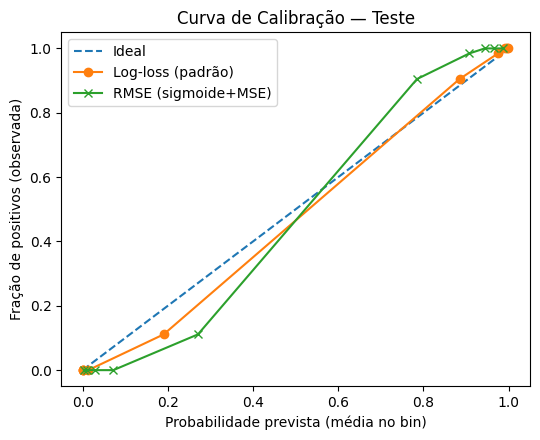

In [12]:
# Bloco 6 — Comparação: RMSE vs Log-loss + Curva de Calibração
# Objetivos do enunciado:
# • Comparar o modelo treinado com RMSE com o modelo logístico padrão (log-loss).
# • Plotar a curva de calibração (“reliability curve”) para verificar se as probabilidades do RMSE
#   estão bem calibradas.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve

# -------------------------------------------------
# 1) Carregar dados locais e separar treino/teste
# -------------------------------------------------
PATH = r"C:\Users\pedro\Downloads\IA-CP2\voice.csv"
if not os.path.exists(PATH):
    PATH = "voice.csv"

df = pd.read_csv(PATH)
y = df["label"].map({"female": 0, "male": 1}).astype(float).values
X = df.drop(columns=["label"]).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# -------------------------------------------------
# 2) Modelo RMSE (reaproveita classe se existir; senão, define rápido)
# -------------------------------------------------
try:
    LogisticRMSE
except NameError:
    class LogisticRMSE:
        def __init__(self, lr=0.05, epochs=3000, l2=0.0, random_state=42):
            self.lr = lr
            self.epochs = epochs
            self.l2 = l2
            self.rng = np.random.RandomState(random_state)
            self.w_ = None
            self.b_ = None

        @staticmethod
        def _sigmoid(z):
            z = np.clip(z, -50, 50)
            return 1.0 / (1.0 + np.exp(-z))

        def fit(self, X, y):
            n, d = X.shape
            self.w_ = self.rng.normal(scale=0.01, size=d)
            self.b_ = 0.0
            for _ in range(self.epochs):
                z = X.dot(self.w_) + self.b_
                p = self._sigmoid(z)
                err = (p - y)
                g_factor = (2.0 / n) * err * p * (1.0 - p)
                grad_w = X.T.dot(g_factor) + self.l2 * self.w_
                grad_b = np.sum(g_factor)
                self.w_ -= self.lr * grad_w
                self.b_ -= self.lr * grad_b
            return self

        def predict_proba(self, X):
            return self._sigmoid(X.dot(self.w_) + self.b_)

        def predict(self, X, threshold=0.5):
            return (self.predict_proba(X) >= threshold).astype(int)

# Treina RMSE
rmse_model = LogisticRMSE(lr=0.05, epochs=3000, l2=0.0, random_state=42).fit(X_train_s, y_train)
p_test_rmse = rmse_model.predict_proba(X_test_s)
y_pred_rmse = (p_test_rmse >= 0.5).astype(int)

acc_rmse = accuracy_score(y_test, y_pred_rmse)
fpr_r, tpr_r, _ = roc_curve(y_test, p_test_rmse)
auc_rmse = auc(fpr_r, tpr_r)

# -------------------------------------------------
# 3) Modelo logístico padrão (log-loss) — baseline
#    (L2, C=1.0; simples e direto)
# -------------------------------------------------
log_model = LogisticRegression(solver="liblinear", penalty="l2", C=1.0, max_iter=2000)
log_model.fit(X_train_s, y_train)
p_test_log = log_model.predict_proba(X_test_s)[:, 1]
y_pred_log = (p_test_log >= 0.5).astype(int)

acc_log = accuracy_score(y_test, y_pred_log)
fpr_l, tpr_l, _ = roc_curve(y_test, p_test_log)
auc_log = auc(fpr_l, tpr_l)

print("=== Comparação no TESTE ===")
print(f"RMSE-model  -> Acurácia: {acc_rmse:.4f} | AUC: {auc_rmse:.4f}")
print(f"Log-loss    -> Acurácia: {acc_log:.4f} | AUC: {auc_log:.4f}")
# Comentário: normalmente o modelo padrão (log-loss) tende a calibrar melhor as probabilidades.

# -------------------------------------------------
# 4) Curva de calibração (reliability curve)
# -------------------------------------------------
# Calcula curva de calibração (fração de positivos vs prob média prevista) em bins
prob_true_rmse, prob_pred_rmse = calibration_curve(y_test, p_test_rmse, n_bins=10, strategy="quantile")
prob_true_log,  prob_pred_log  = calibration_curve(y_test, p_test_log,  n_bins=10, strategy="quantile")

plt.figure(figsize=(5.5, 4.5))
# linha ideal (calibração perfeita)
plt.plot([0, 1], [0, 1], linestyle="--", label="Ideal")

# curvas
plt.plot(prob_pred_log,  prob_true_log,  marker="o", label="Log-loss (padrão)")
plt.plot(prob_pred_rmse, prob_true_rmse, marker="x", label="RMSE (sigmoide+MSE)")

plt.xlabel("Probabilidade prevista (média no bin)")
plt.ylabel("Fração de positivos (observada)")
plt.title("Curva de Calibração — Teste")
plt.legend()
plt.tight_layout()
plt.show()

# Comentários finais (curtos):
# • Se a curva do RMSE ficar mais distante da diagonal que a do log-loss, as probabilidades do RMSE
#   estão menos calibradas (comuns desvios de super/subconfiança).
# • Conclusão simples: compare acurácia/AUC acima e use a curva para julgar calibração — o log-loss
#   geralmente apresenta melhor calibração de probabilidades.


In [ ]:
# Bloco 7 — Discussão Crítica (somente comentários, direto ao ponto)
#
# Por que RMSE é uma péssima ideia para “regressão logística”?
#
# 1) A regressão logística modela PROBABILIDADES (Bernoulli) e o critério natural é a log-loss
#    (log-verossimilhança). É ela que garante estimadores de máxima verossimilhança (MLE),
#    intervalos/testes usuais e boa calibração probabilística. Com RMSE, perdemos essa base estatística.
#
# 2) RMSE (MSE das probabilidades) NÃO penaliza o suficiente previsões erradas de ALTA CONFIANÇA.
#    Exemplo (y=1):
#      - p=0.01 → MSE = (0.01-1)^2 = 0.9801 ; log-loss = -log(0.01) ≈ 4.605
#      - p=0.49 → MSE = (0.49-1)^2 = 0.2601 ; log-loss = -log(0.49) ≈ 0.713
#    A diferença existe nos dois casos, mas a log-loss explode muito mais para “confiança alta e errada”,
#    o que é desejável para não incentivar overconfidence sem evidência.
#
# 3) Otimização mais fraca com RMSE + sigmoide:
#    O gradiente do MSE inclui p*(1-p); perto de 0 ou 1 ele “apaga” (vanishing gradient),
#    dificultando corrigir previsões muito ruins. Na log-loss, o gradiente é proporcional a (p - y),
#    permanecendo forte mesmo nas extremidades (treino mais estável/eficiente).
#
# 4) Multicolinearidade e regularização:
#    L1/L2 com log-loss são padrões bem comportados para classificação. Com RMSE, a calibração e
#    a interpretação dos coeficientes como efeitos em log-odds deixam de ser MLE e perdem validade inferencial.
#
# Conclusão — O que acontece com a INTERPRETAÇÃO e a QUALIDADE das probabilidades ao trocar log-loss por RMSE?
# • Probabilidades tendem a ficar PIOR CALIBRADAS (vide curva de calibração do Bloco 6), com maior
#   chance de sub/superconfiança e menos sensibilidade a erros graves.
# • Coeficientes deixam de ter interpretação “limpa” de MLE em termos de log-odds com propriedades
#   inferenciais padrão (testes/Wald/IC). O modelo ainda mapeia x → sigmoide(w^T x), mas os parâmetros
#   não maximizam a verossimilhança, logo a leitura estatística e a qualidade probabilística se degradam.
# • Em prática: use log-loss para regressão logística. RMSE aqui é apenas um experimento didático.